# K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN) is a simple, non-parametric, and supervised machine learning algorithm used for **classification** and **regression** tasks. It works by finding the closest data points (neighbors) in the feature space and making predictions based on their characteristics.

## How KNN Works

1. **Input Data**:
   - Dataset with labeled instances (classification) or numeric outcomes (regression).
   - Instances are represented as feature vectors in an n-dimensional space.

2. **Distance Metric**:
   - Common distance metrics include:
     - **Euclidean Distance**: \( \sqrt{\sum (x_i - y_i)^2} \)
     - **Manhattan Distance**: \( \sum |x_i - y_i| \)
     - **Minkowski Distance**: Generalized version of the above.

3. **Selecting \( k \)**:
   - \( k \) is the number of nearest neighbors to consider.
   - Typically, \( k \) is an odd number to avoid ties in classification.

4. **Finding Nearest Neighbors**:
   - Calculate the distance between the query point and all other points in the dataset.
   - Identify the \( k \) closest points.

5. **Prediction**:
   - **Classification**: Assign the query point the class that is most common among its \( k \) neighbors (majority voting).
   - **Regression**: Predict the average (or weighted average) value of the \( k \) neighbors.

---

## Strengths
- **Simple to implement**: Relies on intuitive principles.
- **Non-parametric**: No assumptions about the data distribution.
- **Effective for small datasets**: Particularly when the data is clean and well-structured.

## Weaknesses
- **Computationally expensive**: Requires distance calculation for all data points.
- **Sensitive to irrelevant features**: Irrelevant features can mislead distance computations.
- **Curse of dimensionality**: As dimensions increase, distance measures become less meaningful.

---

## Applications
- Handwriting recognition (e.g., digit recognition).
- Image classification.
- Recommender systems.
- Fraud detection.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)


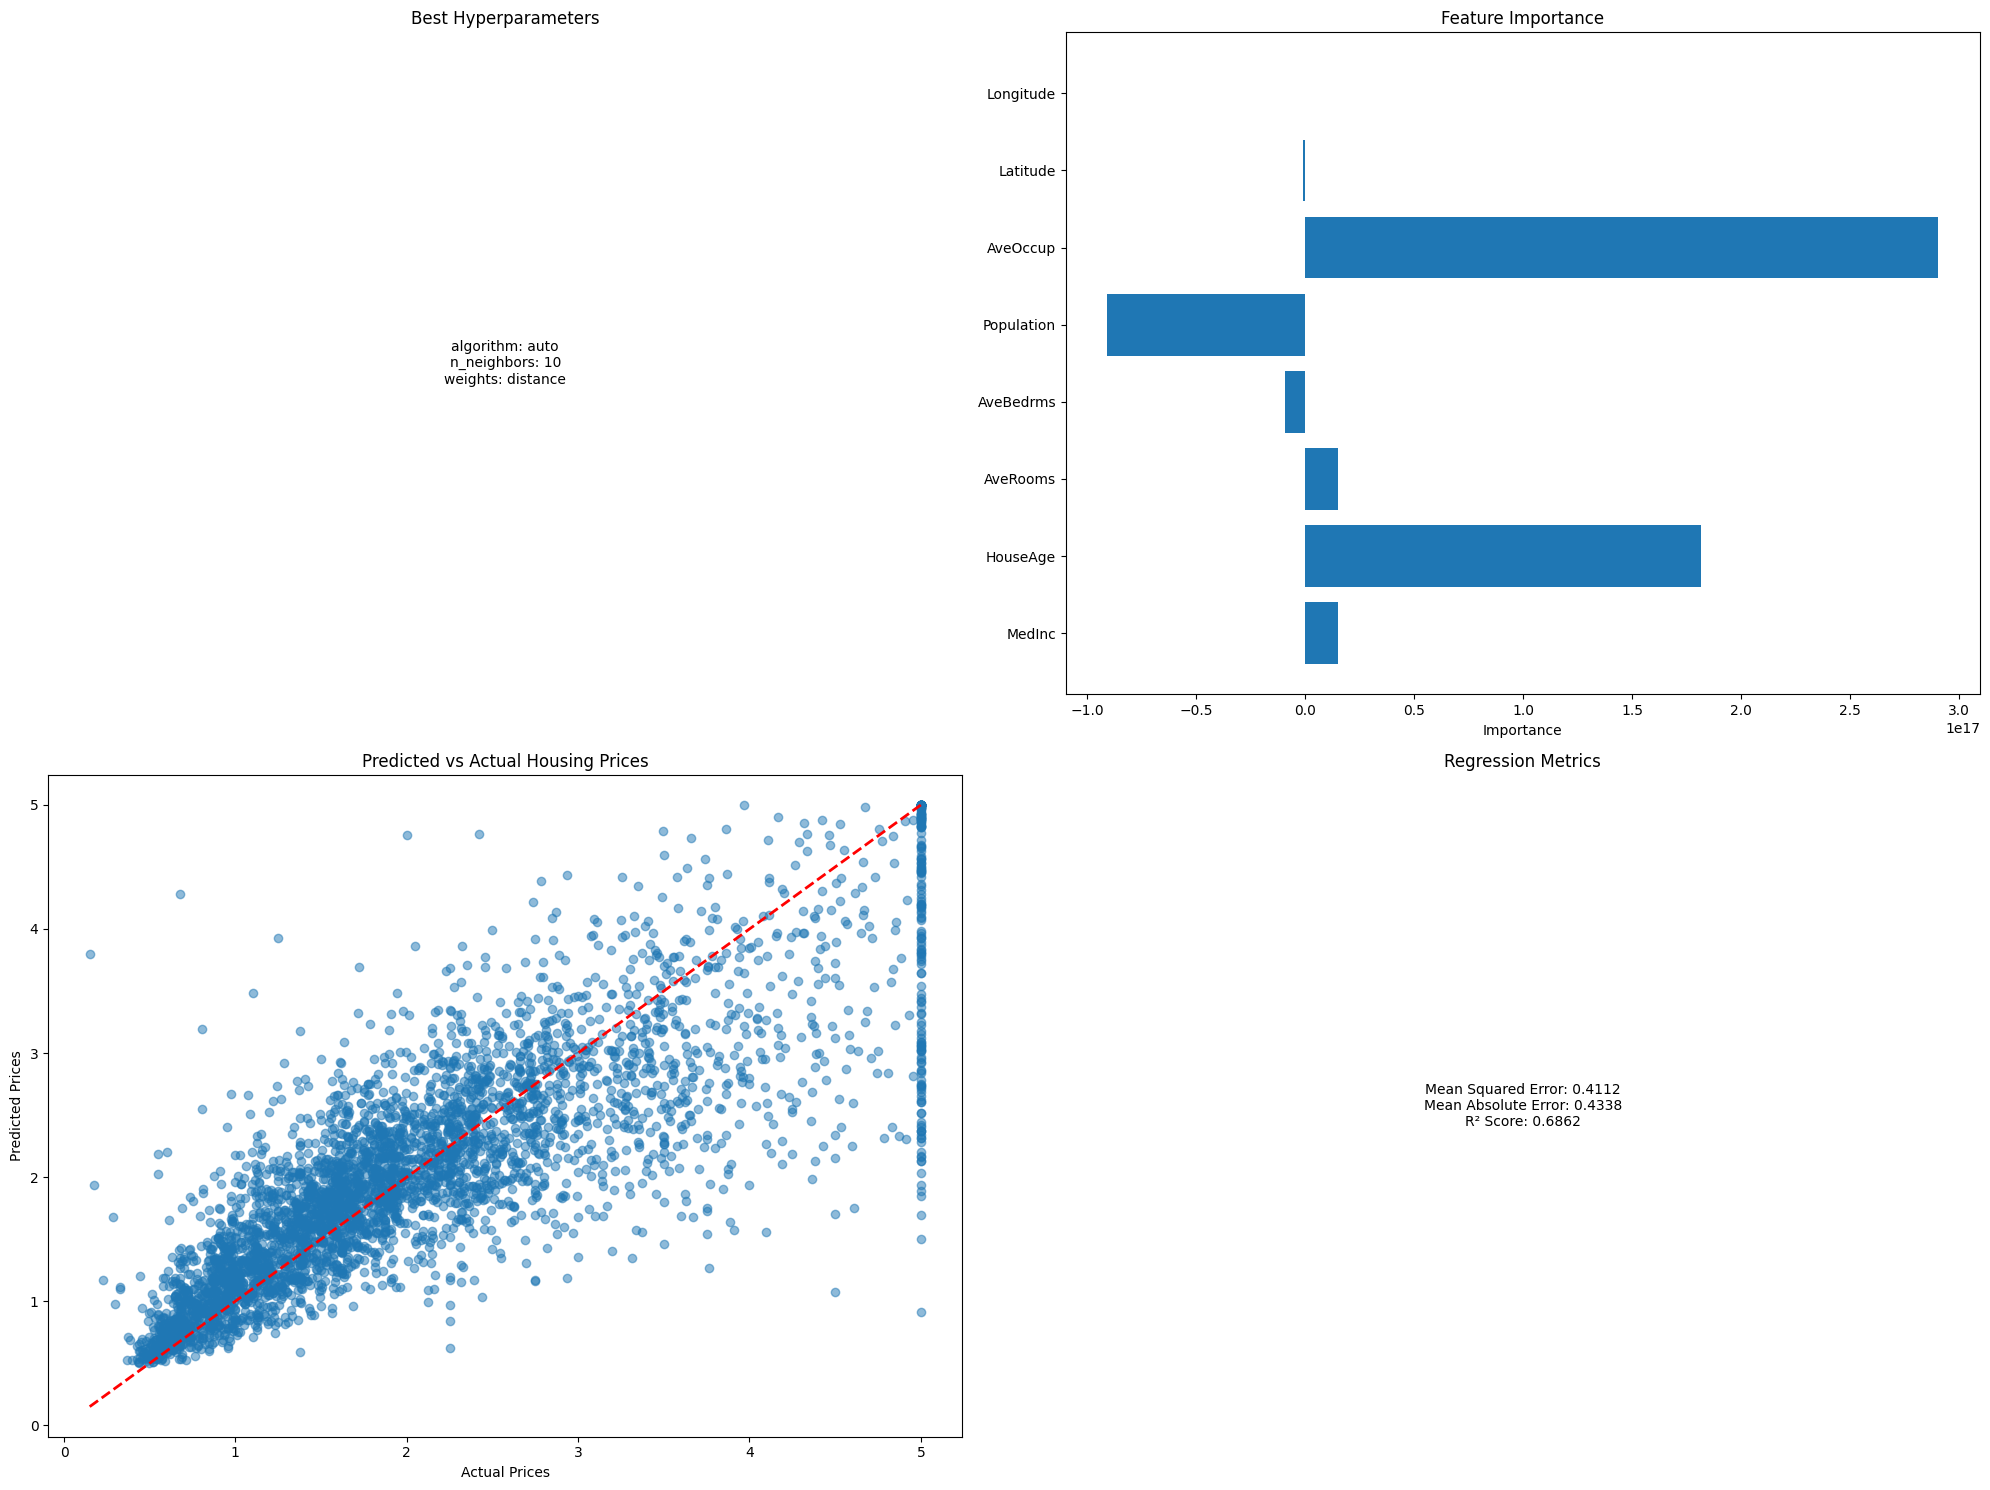


KNN Regression Results:
Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
Mean Squared Error: 0.4112
Mean Absolute Error: 0.4338
R² Score: 0.6862


In [2]:

def load_and_preprocess_data():
    """
    Load California Housing dataset and preprocess
    
    Returns:
    --------
    tuple: (features, target, feature names)
    """
    # Load California Housing dataset
    california = fetch_california_housing()
    X = california.data
    y = california.target
    feature_names = california.feature_names
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, feature_names, scaler

def perform_knn_regression(X, y):
    """
    Perform KNN Regression with hyperparameter tuning
    
    Parameters:
    -----------
    X : array-like
        Scaled feature matrix
    y : array-like
        Target variable
    
    Returns:
    --------
    tuple: (best model, test results)
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Hyperparameter tuning
    param_grid = {
        'n_neighbors': range(1, 31),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }
    
    # Grid Search with Cross-Validation
    grid_search = GridSearchCV(
        KNeighborsRegressor(), 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_knn = grid_search.best_estimator_
    
    # Predictions
    y_pred = best_knn.predict(X_test)
    
    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return best_knn, {
        'mean_squared_error': mse,
        'mean_absolute_error': mae,
        'r2_score': r2,
        'best_params': grid_search.best_params_
    }

def visualize_knn_results(X, y, best_knn, results, feature_names, scaler):
    """
    Create comprehensive visualizations for KNN results
    
    Parameters:
    -----------
    X : array-like
        Scaled feature matrix
    y : array-like
        Target variable
    best_knn : KNeighborsRegressor
        Best KNN model
    results : dict
        Model performance results
    feature_names : list
        Names of features
    scaler : StandardScaler
        Feature scaler
    """
    plt.figure(figsize=(20, 15))
    
    # 1. Hyperparameter Tuning Visualization
    plt.subplot(221)
    cv_results = pd.DataFrame(best_knn.get_params(), index=[0])
    param_text = "\n".join([
        f"{param}: {value}" 
        for param, value in results['best_params'].items()
    ])
    plt.text(0.5, 0.5, param_text, 
             horizontalalignment='center', 
             verticalalignment='center',
             fontsize=10)
    plt.title('Best Hyperparameters')
    plt.axis('off')
    
    # 2. Feature Importance (based on distance-weighted neighbors)
    plt.subplot(222)
    if hasattr(best_knn, 'feature_importances_'):
        importances = best_knn.feature_importances_
    else:
        # If no direct feature importance, use coefficient of variation
        importances = np.std(X, axis=0) / np.mean(X, axis=0)
    
    plt.barh(feature_names, importances)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    
    # 3. Predicted vs Actual Values
    plt.subplot(223)
    # Split data for prediction
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    y_pred = best_knn.predict(X_test)
    
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Predicted vs Actual Housing Prices')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    
    # 4. Regression Metrics
    plt.subplot(224)
    metrics_text = "\n".join([
        f"Mean Squared Error: {results['mean_squared_error']:.4f}",
        f"Mean Absolute Error: {results['mean_absolute_error']:.4f}",
        f"R² Score: {results['r2_score']:.4f}"
    ])
    plt.text(0.5, 0.5, metrics_text, 
             horizontalalignment='center', 
             verticalalignment='center',
             fontsize=10)
    plt.title('Regression Metrics')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional details
    print("\nKNN Regression Results:")
    print(f"Best Hyperparameters: {results['best_params']}")
    print(f"Mean Squared Error: {results['mean_squared_error']:.4f}")
    print(f"Mean Absolute Error: {results['mean_absolute_error']:.4f}")
    print(f"R² Score: {results['r2_score']:.4f}")

def main():
    # Load and preprocess data
    X, y, feature_names, scaler = load_and_preprocess_data()
    
    # Perform KNN Regression
    best_knn, results = perform_knn_regression(X, y)
    
    # Visualize results
    visualize_knn_results(X, y, best_knn, results, feature_names, scaler)

# Run the main function
if __name__ == '__main__':
    main()